In [ ]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import random

random.seed(100)

In [ ]:
import pandas as pd
df = pd.read_csv('dataset_final.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


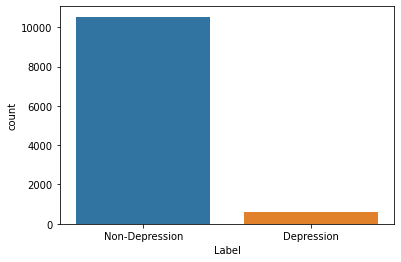

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.countplot(df['Label'])
g.set_xticklabels(['Non-Depression','Depression'])
plt.show()

In [ ]:
# class count
class_count_0, class_count_1 = df['Label'].value_counts()

# Separate class
class_0 = df[df['Label'] == 0]
class_1 = df[df['Label'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (10538, 11)
class 1: (608, 11)


total class of 1 and 0: 1    10538
0    10538
Name: Label, dtype: int64


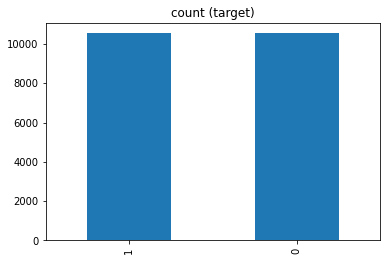

In [ ]:
class_1_over = class_1.sample(class_count_0, replace=True)

test_over = pd.concat([class_1_over, class_0], axis=0)

print("total class of 1 and 0:",test_over['Label'].value_counts())# plot the count after under-sampeling
test_over['Label'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
test_over.to_csv('dataset_oversampling.csv', index=False)
dfover = pd.read_csv('dataset_oversampling.csv')

In [ ]:
tweets = list(dfover['text_tokens_stemmed'])
twlist = tweets[0:200000]
twlist[0:10]

["['seperti', 'tumpuk', 'kerja', 'seperti', 'kesal', 'sangat', 'ingin', 'kuliah', 'mati', 'sangat', 'allah', 'laknat', 'sangat', 'korona', 'sial', 'tidak', 'selesai']",
 "['semster', 'santai', 'semster', 'stress']",
 "['trauma', 'dari', 'pilih', 'diam', 'batin', 'terus', 'tolong', 'capek']",
 "['capek', 'pikir']",
 "['capek', 'sangat', 'allah']",
 "['usia', 'sedih', 'paling', 'satu bulan', 'sekalidua', 'kali', 'maks', 'usia', 'sedih', 'sudah', 'juli', 'gengsss']",
 "['tidak', 'gon', 'na', 'bohong', 'gila', 'saya', 'capek', 'sangat', 'sial', 'gila', 'hari', 'hadap', 'laptop']",
 "['baik', 'serah']",
 "['sudah', 'jam', 'ini', 'tidak percaya diri', 'ayo', 'cepettt']",
 "['kalau', 'sudah', 'jam', 'gin', 'pikir', 'tidak', 'karuan']"]

In [ ]:
vector_size = 32
window = 5

In [ ]:
from gensim.models import FastText

import time

fasttext_model = 'fasttext.model'

print('Generating FastText Vectors ..')

start = time.time()

model = FastText(size=vector_size)
model.build_vocab(tweets)
model.train(tweets, window=window, min_count=1, workers=4, total_examples=model.corpus_count,
           epochs=model.epochs)

print('FastText Created in {} seconds.'.format(time.time() - start))

model.save(fasttext_model)
print('FastText Model saved at {}'.format(fasttext_model))


Generating FastText Vectors ..
FastText Created in 2.7247378826141357 seconds.
FastText Model saved at fasttext.model


In [ ]:
model = FastText.load(fasttext_model)

In [ ]:
x_vectors = model.wv

In [ ]:
labels = dfover['Label']

In [ ]:
len(labels), len(tweets)

(21076, 21076)

In [ ]:
import numpy as np
import keras.backend as K

train_size = int(0.8*(len(tweets)))
test_size = int(0.2*(len(tweets)))

max_no_tokens = 50

indexes = set(np.random.choice(len(tweets), train_size + test_size, replace=False))

x_train = np.zeros((train_size, max_no_tokens, vector_size), dtype=K.floatx())
y_train = np.zeros((train_size, 2), dtype=np.int64)

x_test = np.zeros((test_size, max_no_tokens, vector_size), dtype=K.floatx())
y_test = np.zeros((test_size, 2), dtype=np.int64)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dfover[['Label' , 'text_tokens_stemmed']], test_size=0.2, random_state=1000, shuffle=True)
test_data.to_csv('test_data.csv')
train_data.to_csv('train_data.csv')

In [ ]:
for i, index in enumerate(indexes):
    for t, token in enumerate(tweets[index]):
        if t >= max_no_tokens:
            break
      
        if token not in x_vectors:
            continue
    
        if i < train_size:
            x_train[i, t, :] = x_vectors[token]
        else:
            x_test[i - train_size, t, :] = x_vectors[token]

  
    if i < train_size:
        y_train[i, :] = [1.0, 0.0] if labels[index] == 0 else [0.0, 1.0]
    else:
        y_test[i - train_size, :] = [1.0, 0.0] if labels[index] == 0 else [0.0, 1.0]

In [ ]:
x_train.shape, y_test.shape

((16860, 50, 32), (4215, 2))

In [ ]:
batch_size = 8
no_epochs = 3

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.model_selection import KFold
import numpy as np

num_folds =  10
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 10

for train, test in kfold.split(x_train, y_train):
  model = Sequential()

  model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same',
                 input_shape=(max_no_tokens, vector_size)))
  model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
  model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPooling1D(pool_size=3))

  model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.1))

  model.add(Dense(2, activation='softmax'))

  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

  tensorboard = TensorBoard(log_dir='logs/', histogram_freq=0, write_graph=True, write_images=True)

  model.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 50, 32)            3104      
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 50, 32)            3104      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 16, 32)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)              

In [ ]:
history = model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=no_epochs,
          validation_data=(x_test, y_test), callbacks=[tensorboard, EarlyStopping(min_delta=0.0001, patience=10)])

Epoch 1/3
2108/2108 [==============================] - 86s 38ms/step - loss: 0.7080 - accuracy: 0.5656 - val_loss: 0.9715 - val_accuracy: 0.0000e+00
Epoch 2/3
2108/2108 [==============================] - 78s 37ms/step - loss: 0.6507 - accuracy: 0.6317 - val_loss: 0.7174 - val_accuracy: 0.6550
Epoch 3/3
2108/2108 [==============================] - 78s 37ms/step - loss: 0.5435 - accuracy: 0.7224 - val_loss: 0.8624 - val_accuracy: 0.5129


In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
acc_per_fold = []
loss_per_fold = []
scores = model.evaluate(x_train[test], y_train[test], verbose=0)
print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
acc_per_fold.append(scores[1])
loss_per_fold.append(scores[0])


Score for fold 10: loss of 0.45909950137138367; accuracy of 78.35112810134888%


In [ ]:
test_accuracy = model.evaluate(x=x_test, y=y_test, batch_size=100, verbose=0)
print('Test accuracy : ',test_accuracy)

Test accuracy :  [0.8624261617660522, 0.5129300355911255]


In [ ]:
sample =  test_data.drop(test_data.index[len(test_data)-1])

In [ ]:
prediction = np.argmax(model.predict(x=x_test, batch_size=batch_size, verbose=1), axis=-1)
sample['Prediksi']= (prediction>0.5).astype(int) 
sample[['Label', "Prediksi"]]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


527/527 [==============================] - 3s 5ms/step


,Label,Prediksi
19106,0,1
8182,1,0
5863,1,1
2165,1,1
4297,1,1
...,...,...
15620,0,0
14511,0,0
13707,0,1
2470,1,1


In [ ]:
sample['Prediksi'].value_counts()

0    2162
1    2053
Name: Prediksi, dtype: int64

In [ ]:
sample['Label'].value_counts()

1    2124
0    2091
Name: Label, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix

ytrue = list(sample['Label'])
ypred = list(sample['Prediksi'])

confusion_matrix(ytrue, ypred)

array([[1091, 1000],
       [1071, 1053]])

In [ ]:
hasil_prediksi_0 = sample.loc[sample['Prediksi'] == 0]
hasil_prediksi_0

,Label,text_tokens_stemmed,Prediksi
8182,1,"['sudah', 'serah']",0
13489,0,"['coba', 'saya', 'percaya', 'isi', 'un', 'beli...",0
20219,0,"['selamat', 'pagi', 'dunia', 'tiputipu']",0
10303,1,"['kuliah', 'rabu', 'kamis', 'siksa', 'sangat',...",0
19393,0,"['yeyyy', 'hujan', 'derasss']",0
...,...,...,...
14780,0,"['keunfoll', 'maaf', 'ganggu', 'akun']",0
4564,1,"['antuk', 'tidak', 'tidur', 'karena', 'pikir',...",0
15620,0,"['bantu', 'buat', 'proposal', 'kuantitatif', '...",0
14511,0,"['mantan', 'sudah', 'nikah', 'nich']",0


In [ ]:
hasil_prediksi_1 = sample.loc[sample['Prediksi'] == 1]
hasil_prediksi_1

,Label,text_tokens_stemmed,Prediksi
19106,0,"['sendiri', 'senang']",1
5863,1,"['kuliah', 'daring', 'buat', 'niat', 'ajar', '...",1
2165,1,"['capek', 'sangat', 'tidur', 'jam', 'gin', 'mu...",1
4297,1,"['apa', 'sudah', 'enek', 'sangat', 'kuliah', '...",1
8564,1,"['kuliah', 'daring', 'tidak', 'mikir', 'sudah'...",1
...,...,...,...
6699,1,"['obat', 'sakit', 'kepala', 'kepala', 'sakit',...",1
3019,1,"['kuliah', 'daring', 'buat', 'stress', 'anjing']",1
6823,1,"['fase', 'capek', 'capek', 'ingin', 'sangat', ...",1
13707,0,"['kuliah daring', 'undip', 'down', 'tidak', 's...",1


In [ ]:
hasil_prediksi_0.to_csv('hasilprediksi0.csv')
hasil_prediksi_1.to_csv('hasilprediksi1.csv')

In [ ]:
tn, fp, fn, tp = confusion_matrix(sample['Label'], sample['Prediksi']).ravel()
(tn, fp, fn, tp)

(1091, 1000, 1071, 1053)

In [ ]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = (2*recall*precision)/(recall+precision)
acc = (tp+tn)/(tp+tn+fp+fn)

print('Precision : ',precision)
print('Recall : ',recall) 
print('F1 : ', f1)
print('Accuracy : ', acc)

Precision :  0.5129079396005846
Recall :  0.4957627118644068
F1 :  0.504189609767776
Accuracy :  0.5086595492289443


In [ ]:
model.save('tweets-fasttext-lstm_2.model')

INFO:tensorflow:Assets written to: tweets-fasttext-lstm_2.model/assets
